In [2]:
# CNN + ImageDataGenerator: fashion_mnist
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
np.random.seed(0)
tf.random.set_seed(3)

In [3]:
(x_train_, y_train_), (x_test_, y_test_) = fashion_mnist.load_data()
print(x_train_.shape)
x_train_ = x_train_.reshape(-1, 28, 28, 1).astype('float32') / 255
print(x_train_.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [42]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
# print(x_train[:2])
# print(x_test[:2])

y_train = to_categorical(y_train)
# print(y_train)
y_test = to_categorical(y_test)

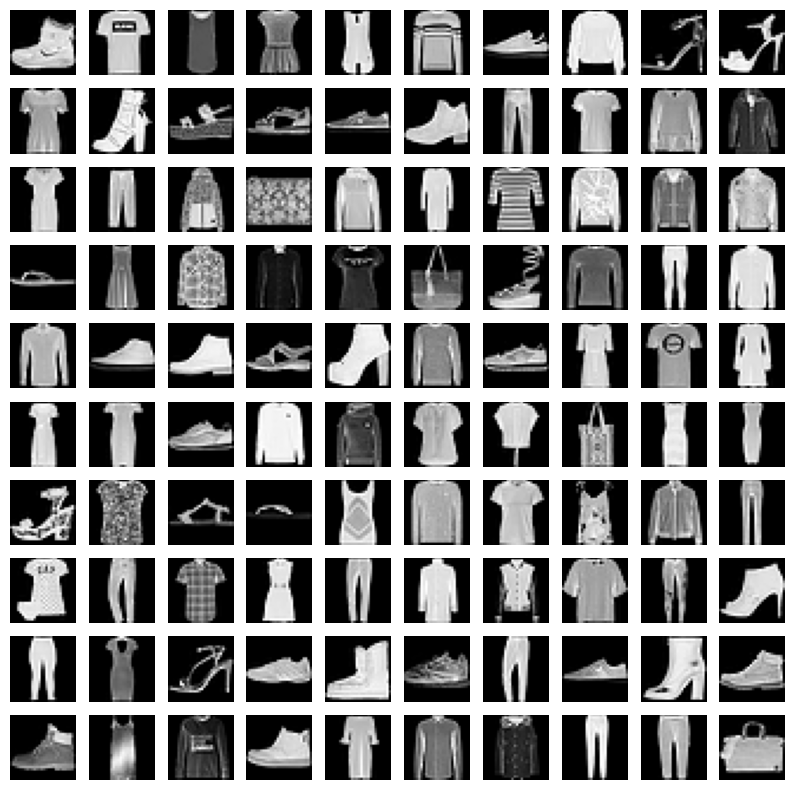

In [43]:
# 이미지 시각화
plt.figure(figsize=(10, 10))
for c in range(100):
    plt.subplot(10, 10, c+1)
    plt.axis('off')
    plt.imshow(x_train[c].reshape(28, 28), cmap='gray')
plt.show()
plt.close()

In [44]:
print(x_train.shape)    # 원본 자료 수 (60000, 28, 28, 1)
print(y_train.shape)    # (60000, 10)

(60000, 28, 28, 1)
(60000, 10)


In [45]:
# 이미지 보강
img_generate = ImageDataGenerator(
    rotation_range = 10,        # 랜덤하게 그림 회전 (각도 0 ~ 100)
    zoom_range = 0.1,           # 확대, 축소
    shear_range = 0.5,          # 축을 중심으로 전환 (모양 기울이기)
    width_shift_range = 0.1,    # 수평 이동
    height_shift_range = 0.1,   # 수직 이동
    horizontal_flip = True,     # 좌우 수평 전화
    vertical_flip = False,      # 상하 수직 전환
)

augment_size = 100  # 증강 샘플 수 100

idx = np.random.randint(x_train.shape[0], size=augment_size)
# print(idx)

x_src = x_train[idx].copy()
y_src = y_train[idx].copy()
# print(x_src)
# print(y_src)

gen = img_generate.flow(
    x_src,
    y=np.zeros(augment_size),
    batch_size=augment_size,
    shuffle=False,
    seed=42
)

x_augmented = next(gen)[0]  # flow 반환값은 제너레이터 객체임. 그래서 next() 다음 배치를 꺼내옴
# 필요하면 원본에 합치기
x_train_aug = np.concatenate([x_train, x_augmented], axis=0)
y_train_aug = np.concatenate([y_train, y_src], axis=0)
print(x_train_aug.shape)

(60100, 28, 28, 1)


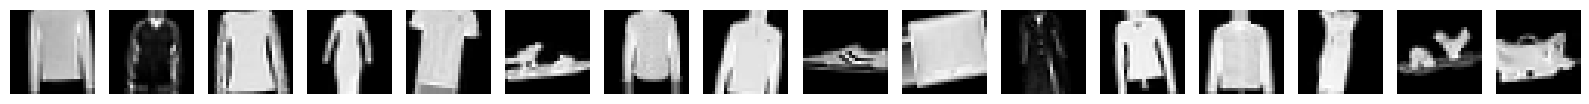

In [46]:
# 확인용 시각화
n = 16
fig, axis = plt.subplots(1, n, figsize=(n, 4))
for i, ax in enumerate(axis):
    ax.imshow(x_augmented[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()
plt.close()

In [60]:
# 이미지 보강
img_generate = ImageDataGenerator(
    rotation_range = 10,        # 랜덤하게 그림 회전 (각도 0 ~ 100)
    zoom_range = 0.1,           # 확대, 축소
    shear_range = 0.2,          # 축을 중심으로 전환 (모양 기울이기)
    width_shift_range = 0.1,    # 수평 이동
    height_shift_range = 0.1,   # 수직 이동
    horizontal_flip = False,    # 좌우 수평 전화
    vertical_flip = False,      # 상하 수직 전환
)

augment_size = 30000  # 증강 샘플 수 100
randidx = np.random.randint(x_train.shape[0], size=augment_size)

x_augment = x_train[randidx].copy()
y_augment = y_train[randidx].copy()

gen = img_generate.flow(
    x_augment,
    y_augment,
    batch_size=augment_size,
    shuffle=False,
    seed=42
)

x_augment, y_augment = next(gen)

# 원본에 합치기
x_train = np.concatenate([x_train, x_augment])
y_train = np.concatenate([y_train, y_augment])
print(x_train.shape)    # (90000, 28, 28, 1)
print(y_train.shape)    # (90000, 10)

(120000, 28, 28, 1)
(120000, 10)


In [49]:
# CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    
    # 데이터 특징 추출 레이어
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.1),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.1),

    tf.keras.layers.Flatten(),

    # 분류기 레이어
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,258 (1.64 MB)

 Trainable params: 429,258 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

None


In [52]:
# 모델 최적화 설정
MODEL_DIR = './mnist/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './mnist/{epoch:02d}-{val_loss:.2f}.keras'
chkpoint = ModelCheckpoint(filepath=modelpath, monitor='val_loss', save_best_only=True, verbose=2)

earlystop = EarlyStopping(monitor='val_loss', patience=5)

In [53]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=2, callbacks=[earlystop, chkpoint])

Epoch 1/100

Epoch 1: val_loss improved from None to 0.56672, saving model to ./mnist/01-0.57.keras
1125/1125 - 12s - 10ms/step - accuracy: 0.7710 - loss: 0.6291 - val_accuracy: 0.7868 - val_loss: 0.5667
Epoch 2/100

Epoch 2: val_loss improved from 0.56672 to 0.49826, saving model to ./mnist/02-0.50.keras
1125/1125 - 10s - 9ms/step - accuracy: 0.8535 - loss: 0.4055 - val_accuracy: 0.8062 - val_loss: 0.4983
Epoch 3/100

Epoch 3: val_loss improved from 0.49826 to 0.45916, saving model to ./mnist/03-0.46.keras
1125/1125 - 10s - 9ms/step - accuracy: 0.8767 - loss: 0.3448 - val_accuracy: 0.8228 - val_loss: 0.4592
Epoch 4/100

Epoch 4: val_loss improved from 0.45916 to 0.42195, saving model to ./mnist/04-0.42.keras
1125/1125 - 10s - 9ms/step - accuracy: 0.8900 - loss: 0.3088 - val_accuracy: 0.8366 - val_loss: 0.4219
Epoch 5/100

Epoch 5: val_loss improved from 0.42195 to 0.41407, saving model to ./mnist/05-0.41.keras
1125/1125 - 10s - 9ms/step - accuracy: 0.8976 - loss: 0.2860 - val_accuracy

In [54]:
print('Test accuracy: %.4f'%(model.evaluate(x_test, y_test)[1]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9199 - loss: 0.2327
Test accuracy: 0.9199


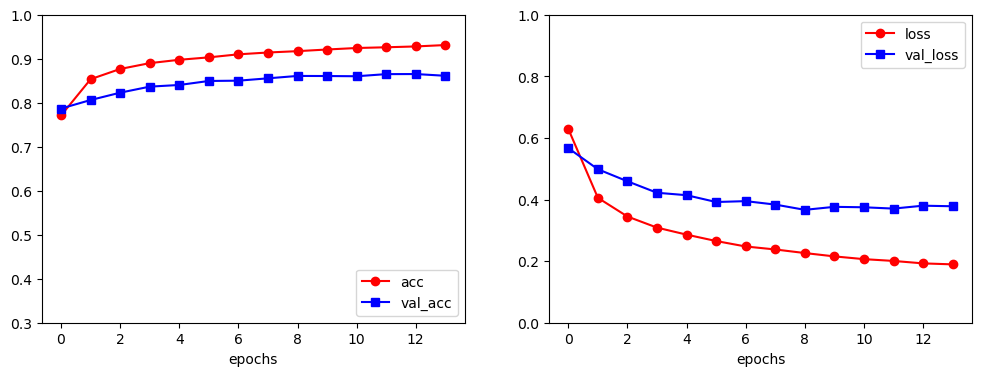

In [59]:
# 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', c='red', label='acc')
plt.plot(history.history['val_accuracy'], marker='s', c='blue', label='val_acc')
plt.xlabel('epochs')
plt.ylim(0.3, 1)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', c='red', label='loss')
plt.plot(history.history['val_loss'], marker='s', c='blue', label='val_loss')
plt.xlabel('epochs')
plt.ylim(0.0, 1)
plt.legend(loc='upper right')

plt.show()
plt.close()